# Adding multiple chips to wafer

In [2534]:
import sys
main_folder_path = r"C:\Users\eeshg\Documents\multimode_sims\Design\fab\LMM4_Dravid"
sys.path.append(main_folder_path)

In [2535]:

import os
import phidl.geometry as pg
from phidl import Device, quickplot as qp
import numpy as np
from utilities import *

# Create a blank wafer layout
wafer = Device("Dravid_wafer_optical")

# Add wafer outline (2-inch wafer = 5.08 cm = 50,800 um diameter)
wafer_radius = 45000 - 2000   # um 2mm edge bead removal
wafer << pg.circle(radius=wafer_radius, layer=0)


DeviceReference (parent Device "circle", ports [], origin (0, 0), rotation 0, x_reflection False)

In [2536]:
show_dict = {'qubits': True,
             'coupler_full': True, 
             'resonators': True }

# Coherence Junctions Triad_half

In [2537]:
juncs_triad_upper_half_x_offset = 0 
juncs_triad_lower_half_y_offset = 0

## Multimode Qubit

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


Importing designs_dxf/DRAVIDQUBITS_OPT-A.gds
Importing designs_dxf/DRAVIDQUBITS_OPT-B.gds
Importing designs_dxf/DRAVIDQUBITS_OPT-C.gds
Importing designs_dxf/DRAVIDQUBITS_OPT-D.gds
Importing designs_dxf/DRAVIDQUBITS_OPT-E.gds


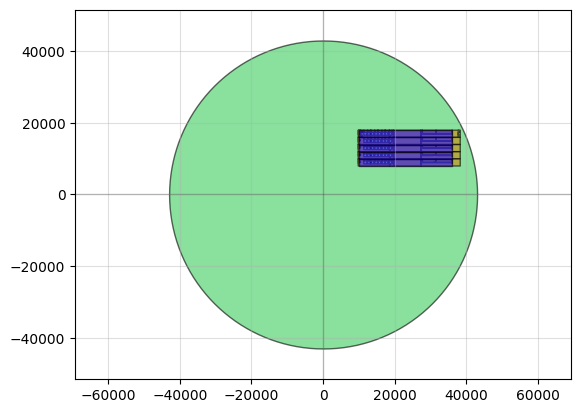

In [2538]:

# Qubits 
# Define path to DXF file to import
qubit_chip_width = 2000 # um 
# path = r"C:\Users\eeshg\Documents\multimode_sims\Design\coupler"  # <-- UPDATE THIS
path = 'designs_dxf/'
with open("multimode/chip_names_qubit.txt", "r") as f:
    chip_names_read = [os.path.basename(line.strip()) for line in f.readlines()]
upper_dxf_files = chip_names_read[:5]
lower_dxf_files = chip_names_read[-5:]


# x pos and y pos offsets for the qubit chips
xpos_offset = -7000 - 20000 + 1251.5 -1.5  + juncs_triad_upper_half_x_offset +8000 # um
ypos_offset = 500 + 4500 -1.5+2500  + juncs_triad_lower_half_y_offset -2500 + 5000  # um - 2500

# Import the GDS structure
if show_dict['qubits']: 
    for idx, file in enumerate(upper_dxf_files):
        wafer, qubit_obj = add_dxf_chip_to_wafer(wafer, file, path, qubit_chip_width, idx, x_offset=xpos_offset, y_offset=ypos_offset, add_bool=False)
        # qubit_obj.rotate(0)  # Rotate the qubit chip by 90 degrees
        wafer, qubit_negative, qubit_bbox = add_qubit_bbox_and_negative_mask(wafer, qubit_obj, qubit_chip_width, idx, xpos_offset=xpos_offset, ypos_offset=ypos_offset)
        qubit_negative.rotate(-90)  # Rotate the qubit chip by 90 degrees
        qubit_bbox.rotate(-90)  # Rotate the bounding box by 90 degrees
    # Save the resulting wafer layout
    # wafer.write_gds("wafer_with_imported_dxf.gds")

# Quick preview (optional)
qp(wafer)



## Coherence Transmons

In [2539]:
folder_lab_designs = "lab_designs/"
coh_trans_files = [
    folder_lab_designs + "SiQbv2_wide_JJ_EEEEEEESH_jc0.1_offset0.0.gds",
    folder_lab_designs + "SiQbv2_wide_JJ_EEEEEEESH_jc0.2_offset0.0.gds",
    folder_lab_designs + "SiQbv2_wide_JJ_EEEEEEESH_jc0.3_offset0.0.gds"
]

In [2540]:
def add_coherence_qubits(
    wafer_device,
    x_offset,
    y_offset,
    qubit_gds=None,
    bbox_size=7000,
    spacing=None,
    num_qubits=1
):
    if spacing is None:
        spacing = 7000

    # Initialize arrays for X and Y coordinates
    blank_x_arr = np.array([0] * num_qubits)
    blank_y_arr = np.array([0] * num_qubits)

    blank_x_arr = blank_x_arr - bbox_size / 2 + x_offset
    blank_y_arr = blank_y_arr - bbox_size / 2 + y_offset
    # blank_x_arr = #[blank_x_arr[i] + (i) * spacing for i in range(num_qubits)]
    blank_y_arr = [blank_y_arr[i] + (i+1) * spacing for i in range(num_qubits)]

    for i in range(num_qubits):
        qubit_raw = pg.import_gds(qubit_gds)
        qubit_pos = pg.copy_layer(qubit_raw, layer=5, new_layer=5)
        qubit_bbox = pg.rectangle(size=(bbox_size, bbox_size), layer=13).move((-bbox_size / 2, -bbox_size / 2))
        dicing_lane_width = 0

        wafer_device << qubit_pos.move((blank_x_arr[i] + bbox_size / 2, blank_y_arr[i] + bbox_size / 2))
        wafer_device << qubit_bbox.move((blank_x_arr[i] + bbox_size / 2 - 50, blank_y_arr[i] + bbox_size / 2))

        xmax = qubit_bbox.xmax
        xmin = qubit_bbox.xmin
        ymax = qubit_bbox.ymax
        ymin = qubit_bbox.ymin

        qubit_pos << pg.cross(length=250, width=100, layer=3).move((xmax + dicing_lane_width / 2, ymax + dicing_lane_width / 2))
        qubit_pos << pg.cross(length=250, width=100, layer=3).move((xmax + dicing_lane_width / 2, ymin - dicing_lane_width / 2))
        qubit_pos << pg.cross(length=250, width=100, layer=3).move((xmin - dicing_lane_width / 2, ymax + dicing_lane_width / 2))
        qubit_pos << pg.cross(length=250, width=100, layer=3).move((xmin - dicing_lane_width / 2, ymin - dicing_lane_width / 2))


In [2541]:
x_offset = 9000 + juncs_triad_upper_half_x_offset +5000
y_offset = 10000 - 5000 + juncs_triad_lower_half_y_offset -500 + 11000
num_copies = 1
if show_dict['qubits']: 
    for idx, file in enumerate(coh_trans_files):
        add_coherence_qubits(wafer, x_offset=x_offset + idx*7000,
                            y_offset=y_offset, 
                            num_qubits=num_copies, qubit_gds=file)

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


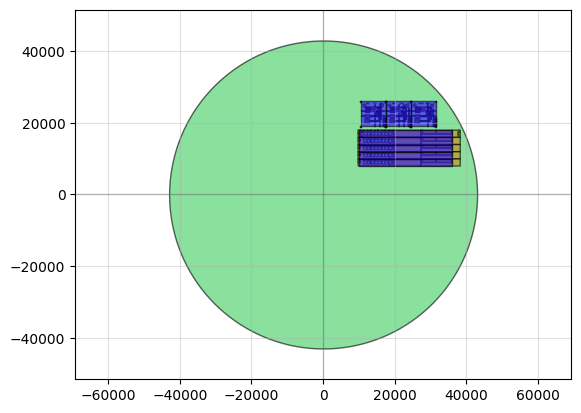

In [2542]:
qp(wafer)

## Ion Milling Mask

In [2543]:
def add_ion_milling_mask(
    wafer_device,
    x_offset,
    y_offset,
    qubit_gds=None,
    bbox_size=7000,
    spacing=None,
    num_qubits=1
):
    if spacing is None:
        spacing = 7000

    # Initialize arrays for X and Y coordinates
    blank_x_arr = np.array([0] * num_qubits)
    blank_y_arr = np.array([0] * num_qubits)

    blank_x_arr = blank_x_arr - bbox_size / 2 + x_offset
    blank_y_arr = blank_y_arr - bbox_size / 2 + y_offset
    # blank_x_arr = #[blank_x_arr[i] + (i) * spacing for i in range(num_qubits)]
    blank_y_arr = [blank_y_arr[i] + (i) * spacing for i in range(num_qubits)]

    for i in range(num_qubits):
        qubit_raw = pg.import_gds(qubit_gds)
        qubit_pos = pg.copy_layer(qubit_raw, layer=1, new_layer=5).move((-bbox_size / 2, -bbox_size / 2))
        qubit_bbox = pg.rectangle(size=(bbox_size, bbox_size), layer=13).move((-bbox_size / 2, -bbox_size / 2))
        dicing_lane_width = 0

        wafer_device << qubit_pos.move((blank_x_arr[i] + bbox_size / 2 + 50, blank_y_arr[i] + bbox_size / 2 + 100))
        wafer_device << qubit_bbox.move((blank_x_arr[i] + bbox_size / 2 - 50, blank_y_arr[i] + bbox_size / 2))

        xmax = qubit_bbox.xmax
        xmin = qubit_bbox.xmin
        ymax = qubit_bbox.ymax
        ymin = qubit_bbox.ymin

        qubit_pos << pg.cross(length=250, width=100, layer=3).move((xmax + dicing_lane_width / 2, ymax + dicing_lane_width / 2))
        qubit_pos << pg.cross(length=250, width=100, layer=3).move((xmax + dicing_lane_width / 2, ymin - dicing_lane_width / 2))
        qubit_pos << pg.cross(length=250, width=100, layer=3).move((xmin - dicing_lane_width / 2, ymax + dicing_lane_width / 2))
        qubit_pos << pg.cross(length=250, width=100, layer=3).move((xmin - dicing_lane_width / 2, ymin - dicing_lane_width / 2))


In [2544]:
x_offset = 12000 + juncs_triad_upper_half_x_offset + 7000*3 
y_offset = 10000 - 5000 #+ 3700
num_copies = 1
ion_milling_file = folder_lab_designs + "ion_mill_mask_v5.gds"
# for idx, file in enumerate(coh_trans_files):
# add_ion_milling_mask(wafer, x_offset=x_offset,
#                         y_offset=y_offset,
#                         num_qubits=1, qubit_gds=ion_milling_file)

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


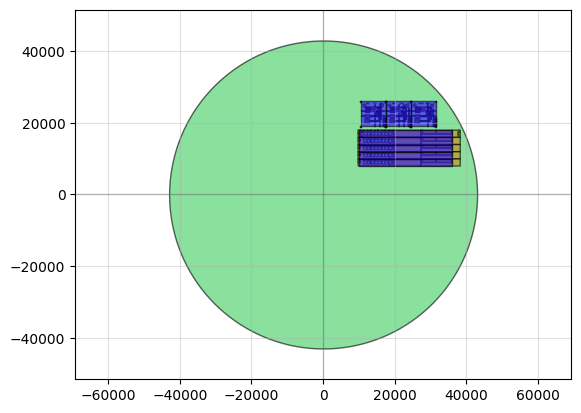

In [2545]:
qp(wafer)

## Multimode Coupler Test Structures

In [2546]:
#Make the following code into a function : add bounding boxes and return negative mas 
# it should take arguments wafer, coupler_chip_obj, coupler_width, idx
# and return the wafer with the negative mask added
# only the coupler text_bbox remain (no coupler chip)
import phidl.geometry as pg

def add_test_structure_negative_mask(wafer, coupler_chip_obj, coupler_width, idx, xpos_offset, ypos_offset):
    coupler_length = 48500
    test_structure_length = 4500 + 2000

    xpos = xpos_offset + (idx * coupler_width)
    ypos = ypos_offset

    # (Optional) draw the visual bounding boxes as before
    # coupler_bbox = pg.rectangle(size=(coupler_width, coupler_length), layer=13)
    # wafer << coupler_bbox.move((xpos - 100, ypos - 100))

    test_structure_bbox_vis = pg.rectangle(size=(coupler_width, test_structure_length), layer=13)
    wafer << test_structure_bbox_vis.move((xpos - 100, ypos + coupler_length - 100))

    # ---- KEY CHANGE ----
    # Build a *test-structures-only* window in the coupler_chip_obj's local coords,
    # then subtract the coupler geometry from that window.
    test_structure_window = pg.rectangle(size=(coupler_width, test_structure_length), layer=14)
    test_structure_window.move((-100, coupler_length - 100))  # place directly above the coupler region

    # A \ B keeps ONLY the top test-structure band and removes whatever the coupler object occupies there
    test_structures_negative = pg.boolean(
        A=test_structure_window,
        B=coupler_chip_obj,
        operation='not',     # A minus B (no reintroduction of the bottom chip)
        layer=5,
        precision=1e-3
    )

    wafer << test_structures_negative.move((xpos, ypos))
    return wafer


Importing C:\Users\eeshg\Documents\multimode_sims\Design\fab\LMM4_Dravid\designs_dxf\DRAVID_COUPLER_OPT-A.gds
Importing C:\Users\eeshg\Documents\multimode_sims\Design\fab\LMM4_Dravid\designs_dxf\DRAVID_COUPLER_OPT-B.gds
Importing C:\Users\eeshg\Documents\multimode_sims\Design\fab\LMM4_Dravid\designs_dxf\DRAVID_COUPLER_OPT-C.gds


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


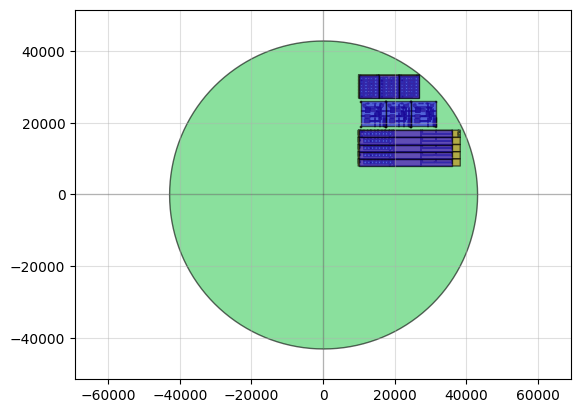

In [2547]:
with open("multimode/chip_names_coupler.txt", "r") as f:
    chip_names_read = [line.strip() for line in f.readlines()]
coupler_files = chip_names_read[:3]
coupler_width = 5650

coupler_test_xoffset = 8000 + juncs_triad_upper_half_x_offset + 2000
coupler_test_yoffset = -21000 + juncs_triad_lower_half_y_offset - 500
# Import the GDS structure
if show_dict['qubits']: 
    for idx, file in enumerate(coupler_files):
        wafer, coupler_chip_obj = add_dxf_chip_to_wafer(wafer, file, path, coupler_width, idx, x_offset=0, y_offset=0,
                                                        add_bool = False)

        wafer = add_test_structure_negative_mask(wafer, coupler_chip_obj, coupler_width, idx, xpos_offset=coupler_test_xoffset, ypos_offset=coupler_test_yoffset)
qp(wafer)

In [2548]:
wafer.write_gds("wafer_with_imported_dxf.gds")

'wafer_with_imported_dxf.gds'

## Bottom half of triad 


In [2549]:
coh_juncs_bottom_half_x_offset = 0
coh_juncs_bottom_half_y_offset = -34000

In [2550]:
# draw multimode qubit, coherence qubits and coupler test structures but on lower half 

# Multimode Qubits (lower half)
if show_dict['qubits']:
    qubit_chip_width = 2000
    xpos_offset_down = 2050+-8000 -7000 - 20000 + 1251.5 - 1.5 - 1500+44100  - coh_juncs_bottom_half_x_offset - 3500 # same as above
    ypos_offset_down = 4500+500 + 4500 -1.5+2500 -1650    # lower half y offset

    for idx, file in enumerate(lower_dxf_files):
        wafer, qubit_obj = add_dxf_chip_to_wafer(wafer, file, path, qubit_chip_width, idx, 
                                                 x_offset=xpos_offset_down,
                                                   y_offset=ypos_offset_down, add_bool=False)
        wafer, qubit_negative, qubit_bbox = add_qubit_bbox_and_negative_mask(wafer, qubit_obj, qubit_chip_width, idx, xpos_offset=xpos_offset_down, ypos_offset=ypos_offset_down)
        qubit_negative.rotate(-90)
        qubit_bbox.rotate(-90)

    # Coherence Qubits (lower half)
    x_offset_down = 12000+5000 - 1650
    y_offset_down = 5000 + coh_juncs_bottom_half_y_offset + 13000 - 10500 - 2050
    num_copies = 1
    for idx, file in enumerate(coh_trans_files):
        add_coherence_qubits(wafer, x_offset=x_offset_down + idx*7000,
                            y_offset=y_offset_down,
                            num_qubits=num_copies, qubit_gds=file)

    #ion milling mask
    x_offset = 12000 + juncs_triad_upper_half_x_offset + 7000*3 
    y_offset = 5000 + coh_juncs_bottom_half_y_offset + 17000
    num_copies = 1
    ion_milling_file = folder_lab_designs + "ion_mill_mask_v5.gds"
    # add_ion_milling_mask(wafer, x_offset=x_offset,
    #                         y_offset=y_offset,
    #                         num_qubits=1, qubit_gds=ion_milling_file)

    # Coupler Test Structures (lower half)
    coupler_test_xoffset_down = 8000 + 2000
    coupler_test_yoffset_down = -17000 + coh_juncs_bottom_half_y_offset - 28500 - 1000
    for idx, file in enumerate(coupler_files):
        wafer, coupler_chip_obj = add_dxf_chip_to_wafer(wafer, file, path, coupler_width, idx, x_offset=0, y_offset=0, add_bool=False)
        wafer = add_test_structure_negative_mask(wafer, coupler_chip_obj, coupler_width, idx, xpos_offset=coupler_test_xoffset_down, ypos_offset=coupler_test_yoffset_down)

Importing designs_dxf/DRAVIDQUBITS_OPT-F.gds
Importing designs_dxf/DRAVIDQUBITS_OPT-G.gds
Importing designs_dxf/DRAVIDQUBITS_OPT-H.gds
Importing designs_dxf/DRAVIDQUBITS_OPT-I.gds
Importing designs_dxf/DRAVIDQUBITS_OPT-J.gds
Importing C:\Users\eeshg\Documents\multimode_sims\Design\fab\LMM4_Dravid\designs_dxf\DRAVID_COUPLER_OPT-A.gds
Importing C:\Users\eeshg\Documents\multimode_sims\Design\fab\LMM4_Dravid\designs_dxf\DRAVID_COUPLER_OPT-B.gds
Importing C:\Users\eeshg\Documents\multimode_sims\Design\fab\LMM4_Dravid\designs_dxf\DRAVID_COUPLER_OPT-C.gds


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


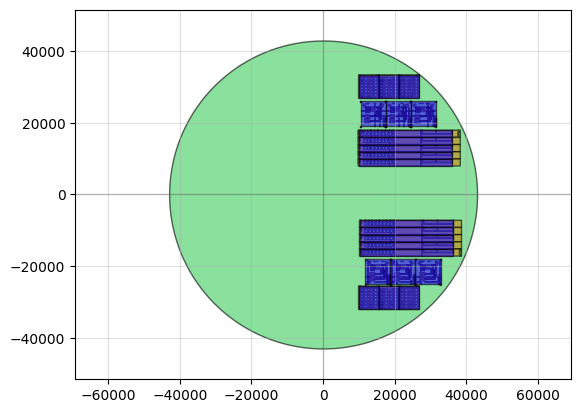

In [2551]:
qp(wafer)

# Tripoles and Resonators Triad

## Tripoles

In [2552]:
resonator_triad_x_offset = 32000 - 500 - 1000
resonator_triad_y_offset = -13000

Importing lab_designs/eesh_tripole_9_2_25_union_with_dicing.gds
Importing lab_designs/eesh_tripole_9_2_25_union_with_dicing.gds


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


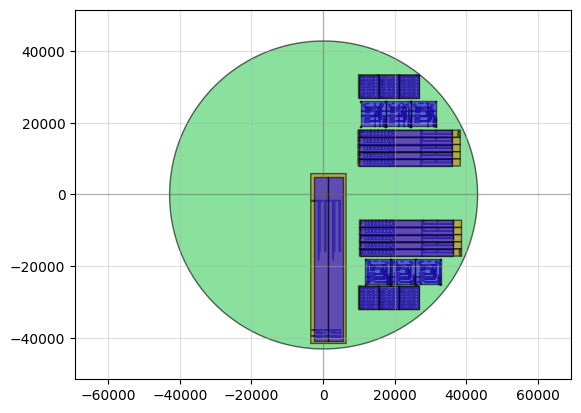

In [2553]:
if show_dict['resonators']:
    tripole_x_offset = resonator_triad_x_offset + 2000
    tripole_y_offset = resonator_triad_y_offset
    matt_chip_name = folder_lab_designs + 'eesh_tripole_9_2_25_union_with_dicing.dxf'
    # optical layer
    add_dxf_chip_to_wafer(wafer, matt_chip_name, "", layer_in=15,
                            layer_out=5, x_offset=tripole_x_offset, y_offset=tripole_y_offset, add_bool=True)
    # dicing layer
    add_dxf_chip_to_wafer(wafer, matt_chip_name, "", layer_in=13,
                            layer_out=13, x_offset=tripole_x_offset, y_offset=tripole_y_offset, add_bool=True)
    qp(wafer)

In [2554]:
# tripole_x_offset = resonator_triad_x_offset - 10000
# tripole_y_offset = resonator_triad_y_offset
# matt_chip_name = folder_lab_designs + 'eesh_tripole_9_2_25_union_with_dicing.dxf'
# # optical layer
# add_dxf_chip_to_wafer(wafer, matt_chip_name, path, layer_in=15,
#                           layer_out=5, x_offset=tripole_x_offset, y_offset=tripole_y_offset, add_bool=True)
# # dicing layer
# add_dxf_chip_to_wafer(wafer, matt_chip_name, path, layer_in=13,
#                           layer_out=13, x_offset=tripole_x_offset, y_offset=tripole_y_offset, add_bool=True)
# qp(wafer)

# 

## Resonators

In [2555]:
def add_coherence_resonators(
    wafer_device,
    x_offset,
    y_offset,
    num_resonators,
    resonator_gds=None,
    bbox_size=7000,
    spacing=None
):
    blank_params = {'size': 7000}
    if spacing is None:
        spacing = 7000

    # Initialize arrays for X and Y coordinates
    blank_x_arr = np.array([-31000] * num_resonators)
    blank_y_arr = np.array([27000] * num_resonators)

    blank_x_arr = blank_x_arr - bbox_size / 2 + x_offset
    blank_y_arr = blank_y_arr - bbox_size / 2 + y_offset
    blank_x_arr = [blank_x_arr[i] + (i) * spacing for i in range(num_resonators)]

    for i in range(num_resonators):
        coh_res_raw = pg.import_gds(resonator_gds)
        coh_res_pos = pg.copy_layer(coh_res_raw, layer=5, new_layer=5)
        coh_res_bbox = pg.rectangle(size=(bbox_size, bbox_size), layer=13).move((-bbox_size / 2, -bbox_size / 2))
        dicing_lane_width = 0

        wafer_device << coh_res_pos.move((blank_x_arr[i] + bbox_size / 2, blank_y_arr[i] + bbox_size / 2))
        wafer_device << coh_res_bbox.move((blank_x_arr[i] + bbox_size / 2 - 50, blank_y_arr[i] + bbox_size / 2))

        xmax = coh_res_bbox.xmax
        xmin = coh_res_bbox.xmin
        ymax = coh_res_bbox.ymax
        ymin = coh_res_bbox.ymin

        # coh_res_pos << pg.cross(length=250, width=100, layer=3).move((xmax + dicing_lane_width / 2, ymax + dicing_lane_width / 2))
        # coh_res_pos << pg.cross(length=250, width=100, layer=3).move((xmax + dicing_lane_width / 2, ymin - dicing_lane_width / 2))
        # coh_res_pos << pg.cross(length=250, width=100, layer=3).move((xmin - dicing_lane_width / 2, ymax + dicing_lane_width / 2))
        # coh_res_pos << pg.cross(length=250, width=100, layer=3).move((xmin - dicing_lane_width / 2, ymin - dicing_lane_width / 2))



Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


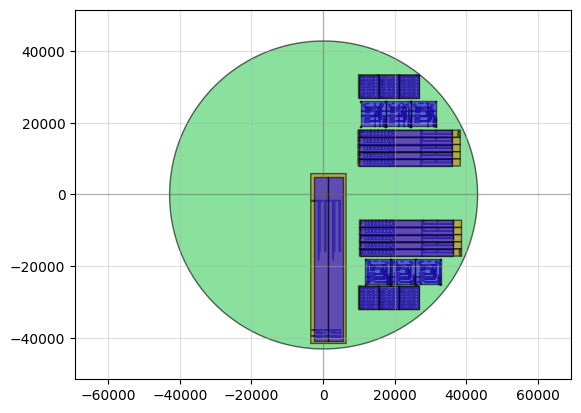

In [2556]:
if show_dict['resonators']:
    None
   # add_coherence_resonators(wafer_device=wafer,
   #                       x_offset=resonator_triad_x_offset-12000 + 2000 -500,
   #                          y_offset=resonator_triad_y_offset+20000,
   #                          num_resonators=3,
   #                          resonator_gds=folder_lab_designs + "center_feedline_resonator_5.gds",
   #                          bbox_size=7000,)

# add_coherence_resonators(wafer_device=wafer,
#                          x_offset=resonator_triad_x_offset-12000,
#                             y_offset=resonator_triad_y_offset-4000-48000-8000,
#                             num_resonators=3,
#                             resonator_gds=folder_lab_designs + "center_feedline_resonator_holes1_mod.gds",
#                             bbox_size=7000,)
qp(wafer)

In [2557]:
if show_dict['resonators']:
   add_coherence_resonators(wafer_device=wafer,
                         x_offset=resonator_triad_x_offset-12000 + 2000 -500,
                            y_offset=resonator_triad_y_offset+20000,
                            num_resonators=3,
                            resonator_gds=folder_lab_designs + "center_feedline_resonator_holes1_mod.gds",
                            bbox_size=7000,)

In [2558]:
# resonator in qubit part 

if show_dict['resonators']:
   add_coherence_resonators(wafer_device=wafer,
                         x_offset=resonator_triad_x_offset-12000 + 2000 -500 + 44000 - 19600,
                            y_offset=resonator_triad_y_offset+20000 - 22000 - 7312-500,
                            num_resonators=1,
                            resonator_gds=folder_lab_designs + "center_feedline_resonator_holes1_mod.gds",
                            bbox_size=7000,)
   add_coherence_resonators(wafer_device=wafer,
                         x_offset=resonator_triad_x_offset-12000 + 2000 -500 + 44000 - 19100,
                            y_offset=resonator_triad_y_offset+20000 - 22000 - 14000 - 825 - 500,
                            num_resonators=1,
                            resonator_gds=folder_lab_designs + "center_feedline_resonator_holes1_mod.gds",
                            bbox_size=7000,)
# add_coherence_resonators(wafer_device=wafer,
#                          x_offset=resonator_triad_x_offset-12000 + 2000 -500,
#                             y_offset=resonator_triad_y_offset+20000,
#                             num_resonators=3,
#                             resonator_gds=folder_lab_designs + "center_feedline_resonator_5.gds",
#                             bbox_size=7000,)

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


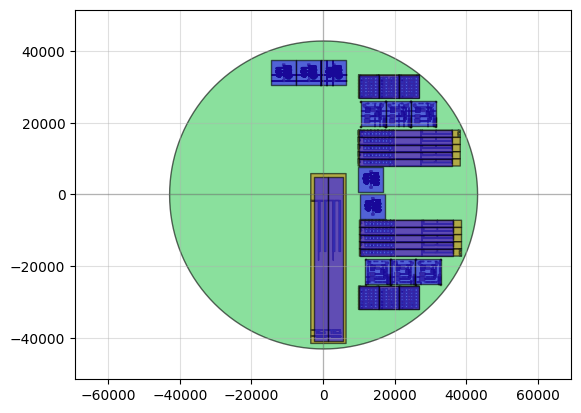

In [2559]:
qp(wafer)

## Kaveh MergeMon Design

In [2560]:
kaveh_filenames = ['circle_grid_release_TARGET',
'SMMS05U_01_mod'
]
kaveh_cellnames = [None,
                    'toplevel', 
                    'toplevel'
                    ]
kaveh_folder = 'kaveh_designs/'
kaveh_yoffset = 11500
kaveh_xoffset = -14000 + 5000 - 2500
# first make the file paths 
kaveh_filepaths = [kaveh_folder + name + '.gds' for name in kaveh_filenames]
for idx, file in enumerate(kaveh_filepaths):
    add_dxf_chip_to_wafer(wafer, file, "", layer_in=5,
                            layer_out=5, x_offset=kaveh_xoffset + idx*7000, 
                            y_offset=kaveh_yoffset, add_bool=True, cell_name= kaveh_cellnames[idx])

Importing kaveh_designs/circle_grid_release_TARGET.gds
Importing kaveh_designs/SMMS05U_01_mod.gds


In [2561]:
idx = 0 
file = kaveh_filepaths[idx]
add_dxf_chip_to_wafer(wafer, file, "", layer_in=5,
                            layer_out=5, x_offset=kaveh_xoffset +33000, 
                            y_offset=kaveh_yoffset - 9401, add_bool=True, cell_name= kaveh_cellnames[idx])

Importing kaveh_designs/circle_grid_release_TARGET.gds


(Device (name "Dravid_wafer_optical" (uid 36302), ports [], aliases [], 0 polygons, 60 references),
 Device (name "extract" (uid 37003), ports [], aliases [], 215 polygons, 0 references))

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


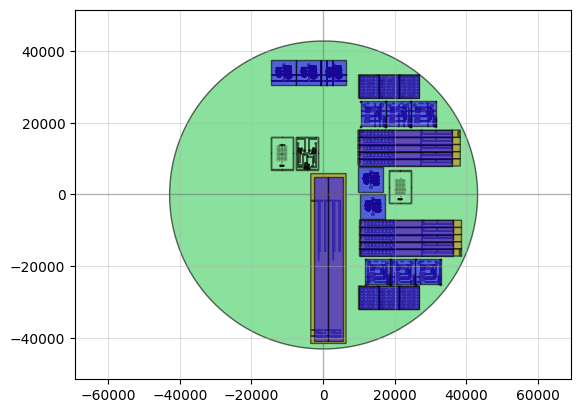

In [2562]:
qp(wafer)

Importing kaveh_designs/SMMS05II_01_mod.gds


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


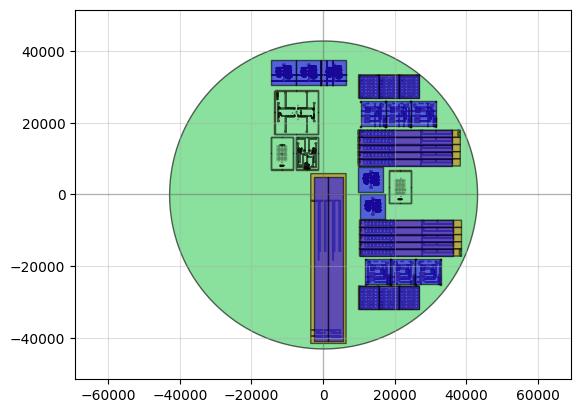

In [2563]:
name = 'SMMS05II_01_mod'
cell_name = 'toplevel'
kaveh_folder = 'kaveh_designs/'
kaveh_yoffset = 23000
kaveh_xoffset = -14000 -1500 + 8000
# first make the file paths 
kaveh_filepath = kaveh_folder + name + '.gds' 

add_dxf_chip_to_wafer(wafer, kaveh_filepath, "", layer_in=5,
                        layer_out=5, x_offset=kaveh_xoffset + idx*7000, 
                        y_offset=kaveh_yoffset, add_bool=True, cell_name=cell_name)
qp(wafer)

## Matthew Qubits 


Importing matthew_design/design_with_added_layer_for_eesh.gds


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


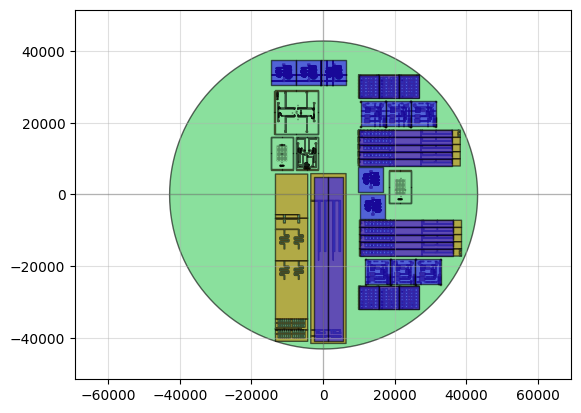

In [2564]:
name = 'design_with_added_layer_for_eesh'
cell_name = None
kaveh_folder = 'matthew_design/'
kaveh_yoffset = -40000 - 500
kaveh_xoffset = -14000 -1500 - 5000 + 500 + 8000 - 800

# first make the file paths 
kaveh_filepath = kaveh_folder + name + '.gds' 

add_dxf_chip_to_wafer(wafer, kaveh_filepath, "", layer_in=1,
                        layer_out=5, x_offset=kaveh_xoffset + idx*7000, 
                        y_offset=kaveh_yoffset, add_bool=True, cell_name=cell_name)
qp(wafer)

## Blanks

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


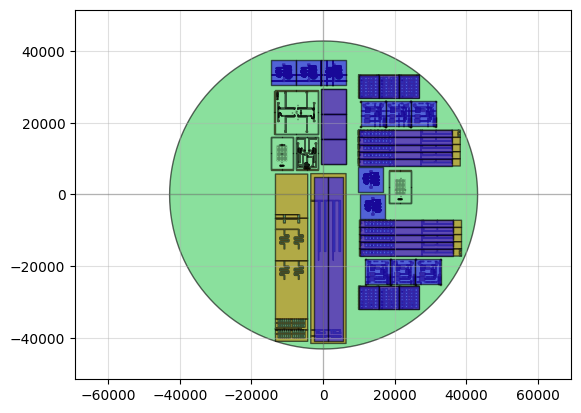

In [2565]:
def add_blanks(
    wafer_device,
    x_offset,
    y_offset,
    num_blanks,
    bbox_size=7000,
    spacing=None
):
    if spacing is None:
        spacing = bbox_size

    blank_x_arr = np.array([-31000] * num_blanks)
    blank_y_arr = np.array([27000] * num_blanks)

    blank_x_arr = blank_x_arr - bbox_size / 2 + x_offset
    blank_y_arr = blank_y_arr - bbox_size / 2 + y_offset
    blank_x_arr = [blank_x_arr[i] + (i) * spacing for i in range(num_blanks)]

    for i in range(num_blanks):
        rect_layer5 = pg.rectangle(size=(bbox_size, bbox_size), layer=5).move((-bbox_size / 2 + i*bbox_size, -bbox_size / 2))
        rect_layer13 = pg.rectangle(size=(bbox_size, bbox_size), layer=13).move((-bbox_size / 2 + i*bbox_size, -bbox_size / 2))
        wafer_device << rect_layer5.move((blank_x_arr[i] + bbox_size / 2, blank_y_arr[i] + bbox_size / 2))
        wafer_device << rect_layer13.move((blank_x_arr[i] + bbox_size / 2, blank_y_arr[i] + bbox_size / 2))

for i in range(3): 
    add_blanks(wafer_device=wafer,
            x_offset=resonator_triad_x_offset+3500,
            y_offset=resonator_triad_y_offset+3000 + 9000 - 7000*i,
            num_blanks=1,
            bbox_size=7000,
            spacing=0)
qp(wafer)


In [2566]:
def add_blanks_metal(
    wafer_device,
    x_offset,
    y_offset,
    num_blanks,
    bbox_size=7000,
    spacing=None
):
    if spacing is None:
        spacing = bbox_size

    blank_x_arr = np.array([-31000] * num_blanks)
    blank_y_arr = np.array([27000] * num_blanks)

    blank_x_arr = blank_x_arr - bbox_size / 2 + x_offset
    blank_y_arr = blank_y_arr - bbox_size / 2 + y_offset
    blank_x_arr = [blank_x_arr[i] + (i) * spacing for i in range(num_blanks)]

    for i in range(num_blanks):
        # rect_layer5 = pg.rectangle(size=(bbox_size, bbox_size), layer=5).move((-bbox_size / 2 + i*bbox_size, -bbox_size / 2))
        rect_layer13 = pg.rectangle(size=(bbox_size, bbox_size), layer=13).move((-bbox_size / 2 + i*bbox_size, -bbox_size / 2))
        # wafer_device << rect_layer5.move((blank_x_arr[i] + bbox_size / 2, blank_y_arr[i] + bbox_size / 2))
        wafer_device << rect_layer13.move((blank_x_arr[i] + bbox_size / 2, blank_y_arr[i] + bbox_size / 2))
# if show_dict['resonators']: 
#     add_blanks_metal(wafer_device=wafer,
#             x_offset=resonator_triad_x_offset-12000,
#             y_offset=resonator_triad_y_offset+3000 + 7500,
#             num_blanks=3,
#             bbox_size=7000,
#             spacing=0)
#     qp(wafer)


# Multimode Coupler Triad

In [2567]:
#Make the following code into a function : add bounding boxes and return negative mas 
# it should take arguments wafer, coupler_chip_obj, coupler_width, idx
# and return the wafer with the negative mask added
def add_coupler_bbox_and_negative_mask(wafer, coupler_chip_obj, coupler_width, idx, xpos_offset,
                                       ypos_offset):
    coupler_length = 48500
    test_structure_length = 4500 +2000

    xpos = xpos_offset + (idx * coupler_width)
    ypos = ypos_offset

    coupler_bbox = pg.rectangle(size=(coupler_width, coupler_length), layer=13)
    wafer << coupler_bbox.move((xpos - 100, ypos - 100))

    test_structure_bbox = pg.rectangle(size=(coupler_width, test_structure_length), layer=13)
    wafer << test_structure_bbox.move((xpos - 100, ypos + coupler_length - 100))

    coupler_chip_bbox = pg.rectangle(size=(coupler_width, coupler_length + test_structure_length), layer=14)
    coupler_chip_bbox.move((-100, -100))

    coupler_negative = pg.boolean(A=coupler_chip_bbox, B=coupler_chip_obj, operation='xor', layer=5)
    wafer << coupler_negative.move((xpos, ypos))

    return wafer

Importing C:\Users\eeshg\Documents\multimode_sims\Design\fab\LMM4_Dravid\designs_dxf\DRAVID_COUPLER_OPT-A.gds
Importing C:\Users\eeshg\Documents\multimode_sims\Design\fab\LMM4_Dravid\designs_dxf\DRAVID_COUPLER_OPT-B.gds
Importing C:\Users\eeshg\Documents\multimode_sims\Design\fab\LMM4_Dravid\designs_dxf\DRAVID_COUPLER_OPT-C.gds


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


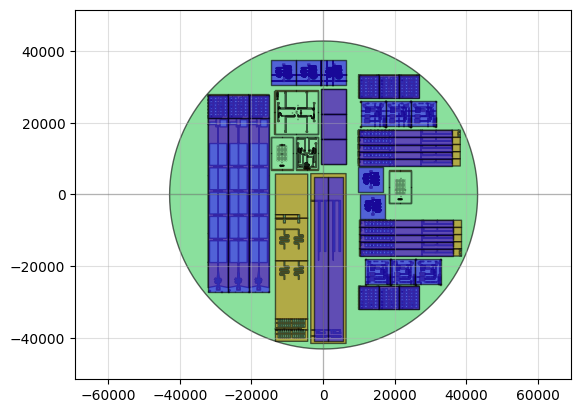

In [2568]:
with open("multimode/chip_names_coupler.txt", "r") as f:
    chip_names_read = [line.strip() for line in f.readlines()]
coupler_files = chip_names_read[:3]
coupler_width = 5650
coup_xoffset = -35000 + 3000
coup_yoffset = -27000
# Import the GDS structure
if show_dict['coupler_full']:
    for idx, file in enumerate(coupler_files):
        wafer, coupler_chip_obj = add_dxf_chip_to_wafer(wafer, file, path, coupler_width, idx, x_offset=coup_xoffset, y_offset=coup_yoffset,
                                                        add_bool = False)

        wafer = add_coupler_bbox_and_negative_mask(wafer, coupler_chip_obj, coupler_width, idx, xpos_offset=coup_xoffset, ypos_offset=coup_yoffset)
    qp(wafer)

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


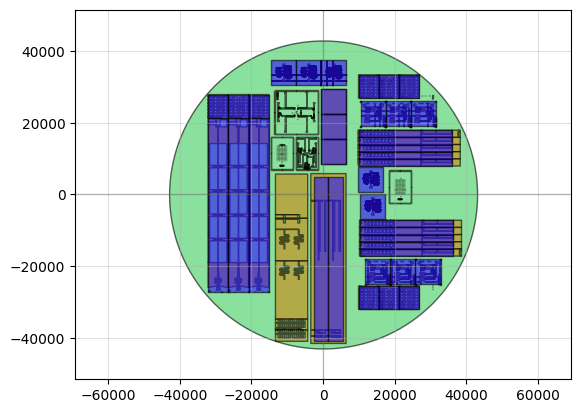

In [2569]:
# coupler ebeam markers extended over right 
# draw squares of 80 micron at a set of x intervals on layer 5 
import numpy as np
def add_ebeam_markers(wafer, xpos_offset, ypos_offset, x_intervals, marker_size=80, y_intervals=None):
    if y_intervals is None:
        y_intervals = [0]
    for y in y_intervals:
        for x in x_intervals:
            xpos = xpos_offset + x
            ypos = ypos_offset + y
            marker = pg.rectangle(size=(marker_size, marker_size), layer=5)
            wafer << marker.move((xpos, ypos))
    return wafer

xpos_offset = 59000/2 - 2000
ypos_offset_down = -26260-80
ypos_offset_up = 25670 +1890#25640-80
x_intervals= np.arange(0, 4000, 1000)

# horizontal ebeam markers
wafer = add_ebeam_markers(wafer, xpos_offset, ypos_offset_down, x_intervals)
wafer = add_ebeam_markers(wafer, xpos_offset, ypos_offset_up, x_intervals)

# vertical 
y_intervals = np.arange(500, 1500, 500)

wafer = add_ebeam_markers(wafer,xpos_offset + x_intervals[-1],ypos_offset_down, [0], y_intervals=y_intervals, marker_size=80)
wafer = add_ebeam_markers(wafer,xpos_offset + x_intervals[-1],ypos_offset_up, [0], y_intervals=-1*y_intervals, marker_size=80)
qp(wafer)

# Saving

In [2570]:
wafer.write_gds("DravidOptical.gds")

'DravidOptical.gds'